# 📎 CIFAR-10 Datasets with PyTorch

## Convolutional Neural Network

### Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 10  # for early stopping

Using device: cuda


### Model

In [2]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


### Datasets

In [3]:
# Data preparation function
def get_data_loaders():
    # Calculate mean and std for CIFAR-10
    transform_simple = transforms.ToTensor()
    temp_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)
    temp_loader = DataLoader(temp_dataset, batch_size=1000, shuffle=False, num_workers=2)

    mean = 0.0
    std = 0.0
    for images, _ in temp_loader:
        batch_mean = torch.mean(images, dim=(0, 2, 3))
        batch_std = torch.std(images, dim=(0, 2, 3))
        mean += batch_mean
        std += batch_std

    mean /= len(temp_loader)
    std /= len(temp_loader)

    print(f"Dataset mean: {mean}, std: {std}")

    # Define transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Split train dataset into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, test_dataset.classes


### Training Model

In [4]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    model.to(device)

    best_val_acc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, train_accs, val_accs


### Evaluation

In [5]:
# Evaluation function
def evaluate(model, test_loader, classes):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate accuracy
    accuracy = 100 * np.mean(all_preds == all_labels)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Print metrics for each class
    print("\nPer-class metrics:")
    for i in range(len(classes)):
        print(f"Class {i} ({classes[i]}): Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

    # Calculate overall metrics
    print("\nOverall metrics:")
    print(f"Precision (macro): {np.mean(precision):.4f}")
    print(f"Recall (macro): {np.mean(recall):.4f}")
    print(f"F1 (macro): {np.mean(f1):.4f}")

    return all_preds, all_labels, all_probs, conf_matrix, precision, recall, f1, accuracy, classes


### Visualisasi

In [6]:
# Visualization functions
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Label the plot
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_roc_curve(all_labels, all_probs, classes):
    # Binarize the labels for ROC curve calculation
    n_classes = len(classes)
    y_test_bin = np.eye(n_classes)[all_labels]

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

    # Calculate and print average AUC
    avg_auc = np.mean(list(roc_auc.values()))
    print(f"\nAverage AUC: {avg_auc:.4f}")

    return roc_auc

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def visualize_predictions(model, test_dataset, classes, num_samples=5):
    model.eval()

    # Set up the plot
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12, 10))

    # Get random samples
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Get the image and label
        image, label = test_dataset[idx]

        # Convert the image for display
        img_display = np.transpose(image.numpy(), (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])  # Approx CIFAR-10 mean
        std = np.array([0.2470, 0.2435, 0.2616])   # Approx CIFAR-10 std
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        # Make prediction
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            probs = F.softmax(output, dim=1)[0]
            _, predicted = torch.max(output, 1)

        # Display image
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'True: {classes[label]}')
        axes[i, 0].axis('off')

        # Display probabilities
        top_k = 3
        topk_probs, topk_indices = torch.topk(probs, top_k)

        # Plot bars
        bars = axes[i, 1].barh(range(top_k), topk_probs.cpu())
        axes[i, 1].set_yticks(range(top_k))
        axes[i, 1].set_yticklabels([classes[idx] for idx in topk_indices.cpu()])
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].set_title(f'Predicted: {classes[predicted.item()]}')

        # Add probability values
        for bar, prob in zip(bars, topk_probs.cpu()):
            axes[i, 1].text(prob + 0.01, bar.get_y() + bar.get_height()/2, f'{prob:.2f}',
                           va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

Loading and preparing data...


100%|██████████| 170M/170M [00:02<00:00, 76.9MB/s]


Dataset mean: tensor([0.4914, 0.4822, 0.4465]), std: tensor([0.2470, 0.2434, 0.2615])
Creating model...
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 1.3701, Train Acc: 50.21%, Val Loss: 1.2032, Val Acc: 58.76%
Epoch 2/100, Train Loss: 1.0537, Train Acc: 62.20%, Val Loss: 0.9383, Val Acc: 66.83%
Epoch 3/100, Train Loss: 0.9446, Train Acc: 66.38%, Val Loss: 0.8685, Val Acc: 69.78%
Epoch 4/100, Train Loss: 0.8641, Train Acc: 69.65%, Val Loss: 0.8375, Val Acc: 70.42%
Epoch 5/100, Train Loss: 0.8162, Train Acc: 71.21%, Val Loss: 0.7715, Val Acc: 72.83%
Epoch 6/100, Train Loss: 0.7765, Train Acc: 72.47%, Val Loss: 0.7850, Val Acc: 72.06%
Epoch 7/100, Train Loss: 0.7346, Train Acc: 74.05%, Val Loss: 0.7193, Val Acc: 75.02%
Epoch 8/100, Train Loss: 0.7058, Train Acc: 75.04%, Val Loss: 0.6808, Val Acc: 76.29%
Epoch 9/100, Train Loss: 0.6815, Train Acc: 76.13%, Val Loss: 0.7475, Val Acc: 74.24%
Epoch 10/100, Train Loss: 0.6612, Train Acc: 76.75%, Val Loss: 0.6525, Val Acc: 77.17%
Epoch 11/100, Train Loss: 0.6411, Train Acc: 77.38%, Val Loss: 0.6409, Val Acc: 77.61%
Epoch 12/100, Train Loss: 0.6159, Train Acc: 78.56%,

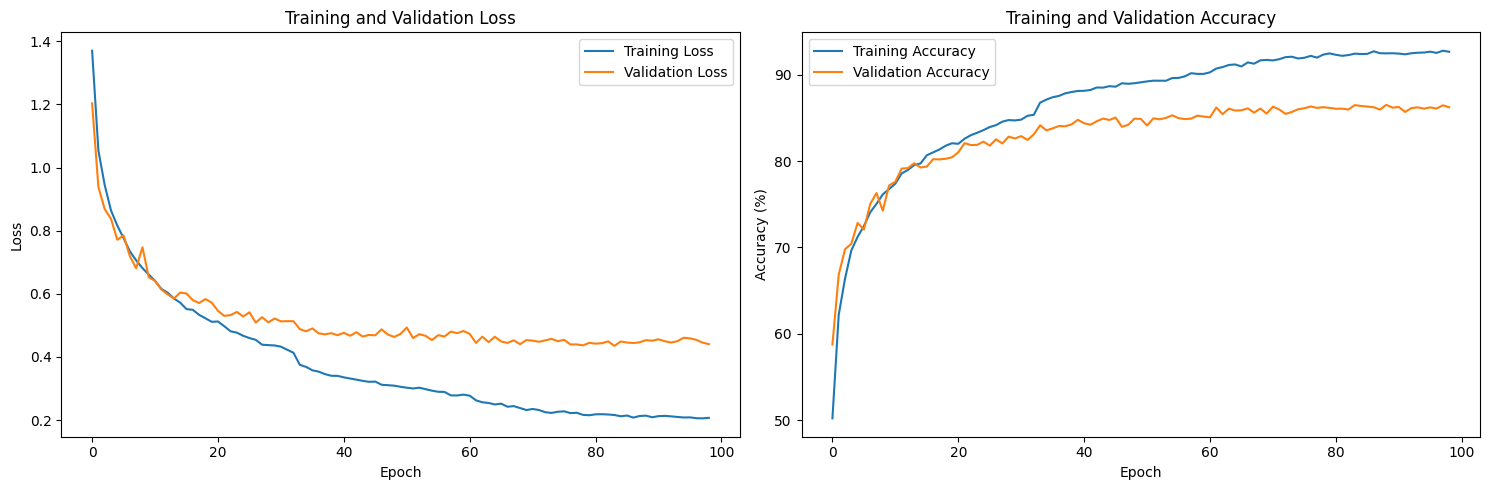

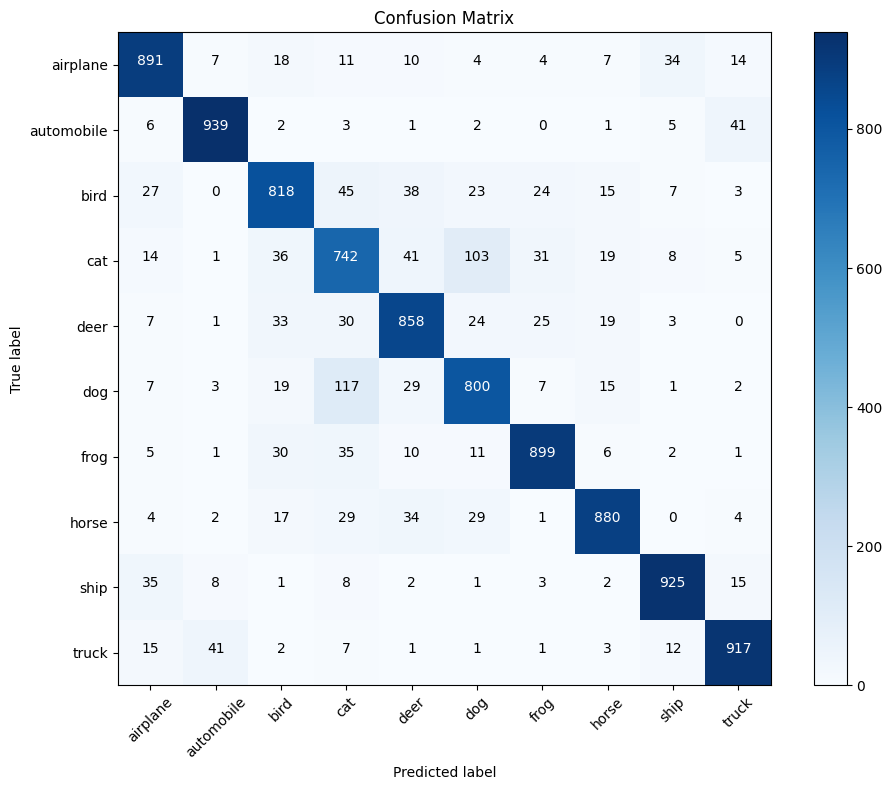

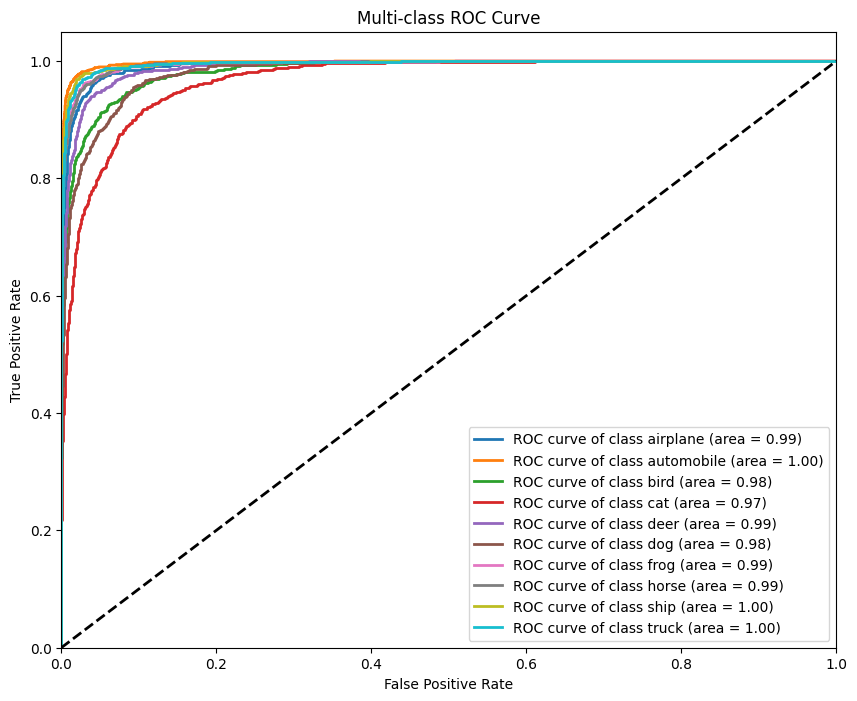


Average AUC: 0.9895


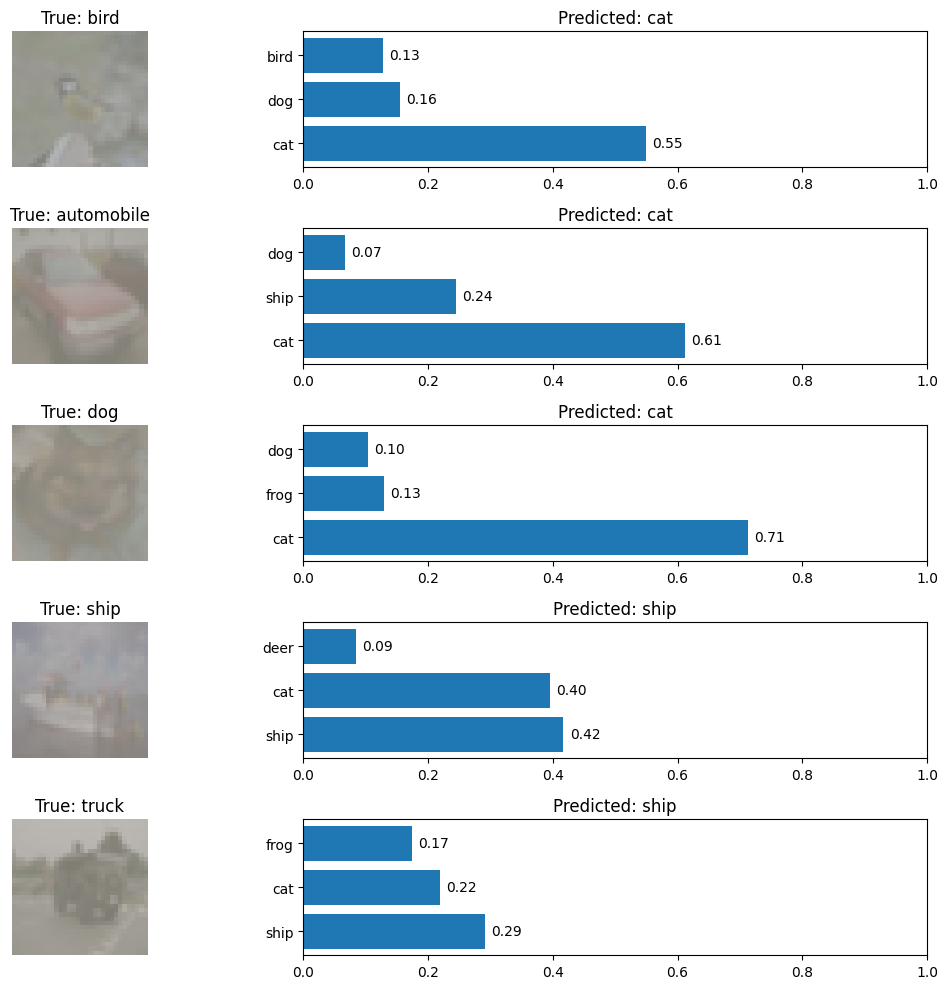


Saving model...

Done!


In [7]:
def main():
    # Get data loaders
    print("Loading and preparing data...")
    train_loader, val_loader, test_loader, classes = get_data_loaders()

    # Create model, loss function, and optimizer
    print("Creating model...")
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Training
    print("Starting training...")
    start_time = time.time()
    model, train_losses, val_losses, train_accs, val_accs = train(
        model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Evaluation
    print("\nEvaluating model...")
    all_preds, all_labels, all_probs, conf_matrix, precision, recall, f1, accuracy, classes = evaluate(model, test_loader, classes)

    # Visualizations
    print("\nGenerating visualizations...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(conf_matrix, classes)
    roc_auc = plot_roc_curve(all_labels, all_probs, classes)

    # Get test dataset for visualization
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                             transform=transforms.ToTensor())
    visualize_predictions(model, test_dataset, classes)

    # Save final model
    print("\nSaving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'classes': classes
    }, 'final_model.pth')

    print("\nDone!")

if __name__ == "__main__":
    main()

## MLP

### Library

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 10  # for early stopping

Using device: cuda


### Model

In [9]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Input dimensions: CIFAR-10 images are 3x32x32 = 3072 flattened
        self.flatten = nn.Flatten()

        # First hidden layer
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        # Second hidden layer
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)

        # Third hidden layer
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)

        # Output layer
        self.fc4 = nn.Linear(256, 10)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)

        # First hidden layer
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Second hidden layer
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Third hidden layer
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Output layer
        x = self.fc4(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


### Datasets

In [10]:
# Data preparation function
def get_data_loaders():
    # Calculate mean and std for CIFAR-10
    transform_simple = transforms.ToTensor()
    temp_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)
    temp_loader = DataLoader(temp_dataset, batch_size=1000, shuffle=False, num_workers=2)

    mean = 0.0
    std = 0.0
    for images, _ in temp_loader:
        batch_mean = torch.mean(images, dim=(0, 2, 3))
        batch_std = torch.std(images, dim=(0, 2, 3))
        mean += batch_mean
        std += batch_std

    mean /= len(temp_loader)
    std /= len(temp_loader)

    print(f"Dataset mean: {mean}, std: {std}")

    # Define transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Split train dataset into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, test_dataset.classes


### Training Model

In [11]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    model.to(device)

    best_val_acc = 0.0
    early_stop_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_mlp_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model for evaluation
    model.load_state_dict(torch.load('best_mlp_model.pth'))

    return model, train_losses, val_losses, train_accs, val_accs


### Evaluation

In [12]:
# Evaluation function
def evaluate(model, test_loader, classes):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate accuracy
    accuracy = 100 * np.mean(all_preds == all_labels)
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Print metrics for each class
    print("\nPer-class metrics:")
    for i in range(len(classes)):
        print(f"Class {i} ({classes[i]}): Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

    # Calculate overall metrics
    print("\nOverall metrics:")
    print(f"Precision (macro): {np.mean(precision):.4f}")
    print(f"Recall (macro): {np.mean(recall):.4f}")
    print(f"F1 (macro): {np.mean(f1):.4f}")

    return all_preds, all_labels, all_probs, conf_matrix, precision, recall, f1, accuracy, classes


### Visualisasi

In [13]:
# Visualization functions
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Label the plot
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig('mlp_confusion_matrix.png')
    plt.show()

def plot_roc_curve(all_labels, all_probs, classes):
    # Binarize the labels for ROC curve calculation
    n_classes = len(classes)
    y_test_bin = np.eye(n_classes)[all_labels]

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('mlp_roc_curve.png')
    plt.show()

    # Calculate and print average AUC
    avg_auc = np.mean(list(roc_auc.values()))
    print(f"\nAverage AUC: {avg_auc:.4f}")

    return roc_auc

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('mlp_training_history.png')
    plt.show()

def visualize_predictions(model, test_dataset, classes, num_samples=5):
    model.eval()

    # Set up the plot
    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12, 10))

    # Get random samples
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Get the image and label
        image, label = test_dataset[idx]

        # Convert the image for display
        img_display = np.transpose(image.numpy(), (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])  # Approx CIFAR-10 mean
        std = np.array([0.2470, 0.2435, 0.2616])   # Approx CIFAR-10 std
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        # Make prediction
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            probs = F.softmax(output, dim=1)[0]
            _, predicted = torch.max(output, 1)

        # Display image
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'True: {classes[label]}')
        axes[i, 0].axis('off')

        # Display probabilities
        top_k = 3
        topk_probs, topk_indices = torch.topk(probs, top_k)

        # Plot bars
        bars = axes[i, 1].barh(range(top_k), topk_probs.cpu())
        axes[i, 1].set_yticks(range(top_k))
        axes[i, 1].set_yticklabels([classes[idx] for idx in topk_indices.cpu()])
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].set_title(f'Predicted: {classes[predicted.item()]}')

        # Add probability values
        for bar, prob in zip(bars, topk_probs.cpu()):
            axes[i, 1].text(prob + 0.01, bar.get_y() + bar.get_height()/2, f'{prob:.2f}',
                           va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('mlp_sample_predictions.png')
    plt.show()

Loading and preparing data...
Dataset mean: tensor([0.4914, 0.4822, 0.4465]), std: tensor([0.2470, 0.2434, 0.2615])
Creating MLP model...
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 2.2174, Train Acc: 22.84%, Val Loss: 1.8235, Val Acc: 33.31%
Epoch 2/100, Train Loss: 1.9062, Train Acc: 30.37%, Val Loss: 1.7372, Val Acc: 37.36%
Epoch 3/100, Train Loss: 1.8214, Train Acc: 33.48%, Val Loss: 1.6900, Val Acc: 39.32%
Epoch 4/100, Train Loss: 1.7645, Train Acc: 35.79%, Val Loss: 1.6537, Val Acc: 41.02%
Epoch 5/100, Train Loss: 1.7298, Train Acc: 37.03%, Val Loss: 1.6159, Val Acc: 41.50%
Epoch 6/100, Train Loss: 1.6998, Train Acc: 38.40%, Val Loss: 1.5878, Val Acc: 42.55%
Epoch 7/100, Train Loss: 1.6766, Train Acc: 39.12%, Val Loss: 1.5672, Val Acc: 43.22%
Epoch 8/100, Train Loss: 1.6608, Train Acc: 39.65%, Val Loss: 1.5585, Val Acc: 43.26%
Epoch 9/100, Train Loss: 1.6341, Train Acc: 40.85%, Val Loss: 1.5315, Val Acc: 44.97%
Epoch 10/100, Train Loss: 1.6307, Train Acc: 40.84%, Val Loss: 1.5182, Val Acc: 45.65%
Epoch 11/100, Train Loss: 1.6089, Train Acc: 41.82%, Val Loss: 1.5049, Val Acc: 45.18%
Epoch 12/100, Train Loss: 1.5979, Train Acc: 42.10%,

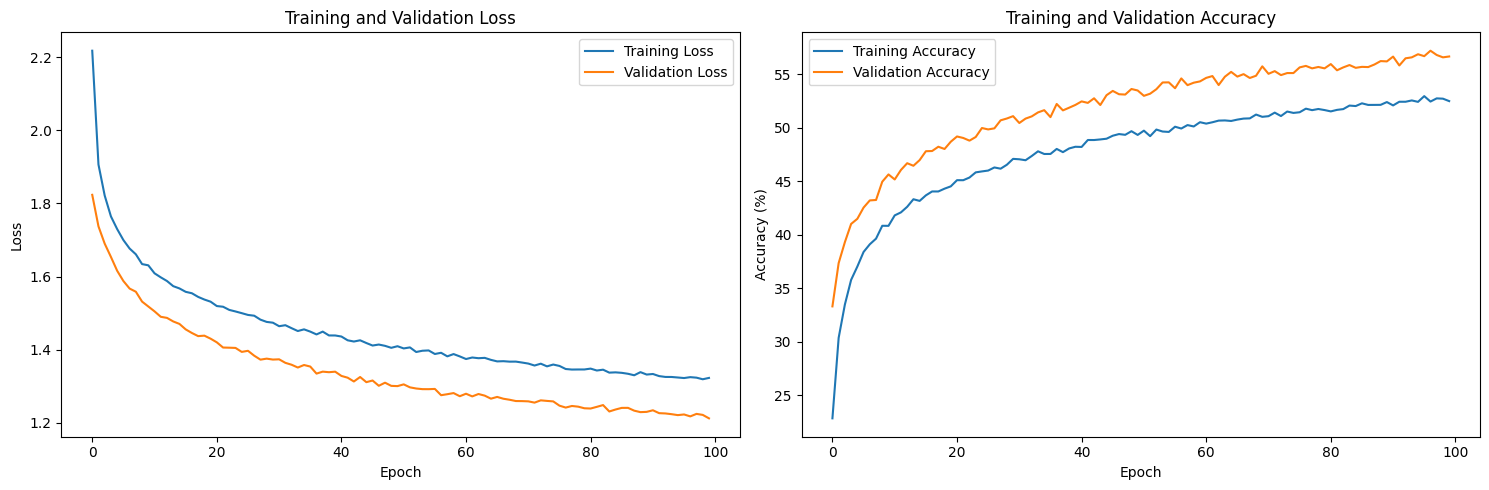

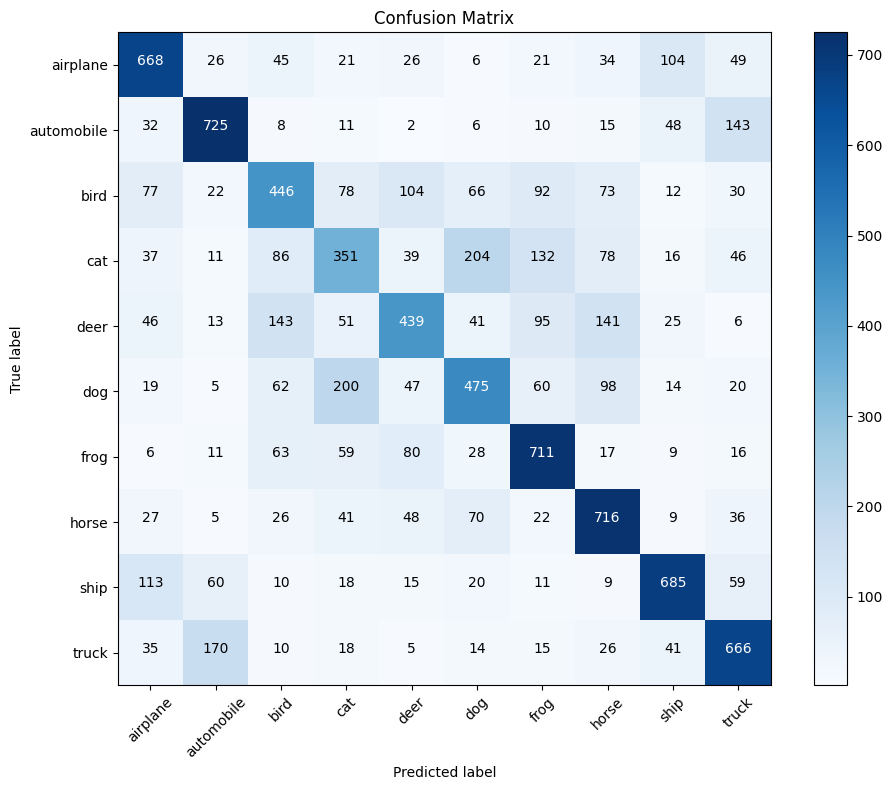

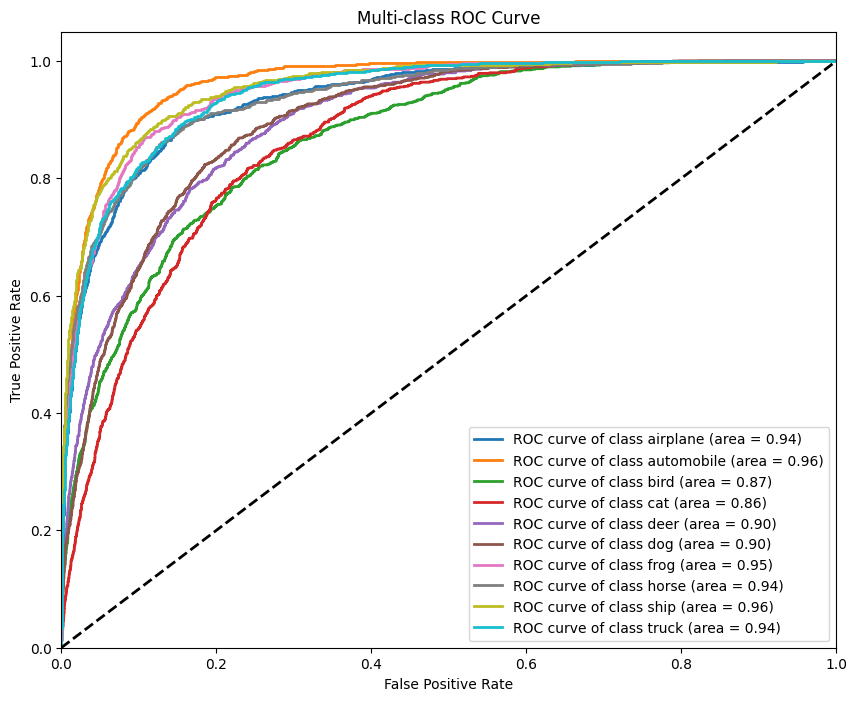


Average AUC: 0.9214


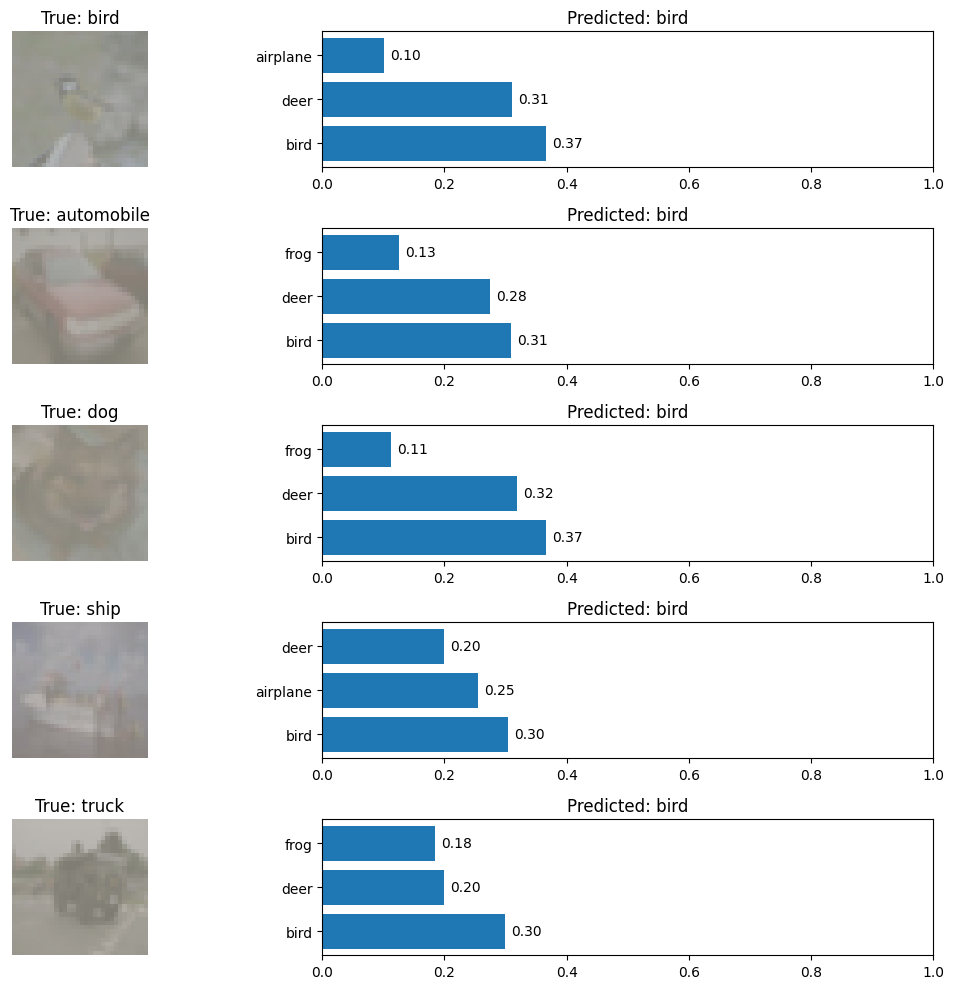


Saving model...

Done!


In [14]:
def main():
    # Get data loaders
    print("Loading and preparing data...")
    train_loader, val_loader, test_loader, classes = get_data_loaders()

    # Create model, loss function, and optimizer
    print("Creating MLP model...")
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Training
    print("Starting training...")
    start_time = time.time()
    model, train_losses, val_losses, train_accs, val_accs = train(
        model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Evaluation
    print("\nEvaluating model...")
    all_preds, all_labels, all_probs, conf_matrix, precision, recall, f1, accuracy, classes = evaluate(model, test_loader, classes)

    # Visualizations
    print("\nGenerating visualizations...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(conf_matrix, classes)
    roc_auc = plot_roc_curve(all_labels, all_probs, classes)

    # Get test dataset for visualization
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                             transform=transforms.ToTensor())
    visualize_predictions(model, test_dataset, classes)

    # Save final model
    print("\nSaving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'classes': classes
    }, 'final_mlp_model.pth')

    print("\nDone!")

if __name__ == "__main__":
    main()